In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.utils import compute_class_weight
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D,BatchNormalization,Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



In [2]:
image_size = 224
batch_size = 8

train_data_dir = r"D:\Personal\Ocular Toxoplasmosis\data\BinaryClassification\train"
validation_data_dir = r"D:\Personal\Ocular Toxoplasmosis\data\BinaryClassification\val"

train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(image_size, image_size), batch_size=batch_size, class_mode='categorical')
val_generator = validation_datagen.flow_from_directory( validation_data_dir, target_size=(image_size, image_size), batch_size=batch_size, 
                                                       class_mode='categorical', shuffle=False)

# Define the number of classes in your dataset
num_classes = train_generator.num_classes

# Calculate class weights
labels = train_generator.classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = dict(zip(np.unique(labels), class_weights))
print(class_weights)

Found 298 images belonging to 2 classes.
Found 75 images belonging to 2 classes.


In [14]:
l = []

def modelfunction(base):
    
    x = base.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    predictions = tf.keras.layers.Dense(units=num_classes, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.02, l2=0.02))(x)
    model = Model(inputs=base.input, outputs=predictions)
    return model 

def get_callbacks(weight):
    
    checkpoint = ModelCheckpoint(weight, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.2, min_lr=0.0002)
    callbacks = [earlystop, checkpoint, learning_rate_reduction]
    return callbacks

def evaluate(model, generator_test, model_name):
    history = model.evaluate(generator_test)
    
    data = {}
    data['Model'] = model_name
    data['loss'] = history[0]
    data['accuracy'] = history[1]
    data['auc'] = history[2]
    data['precision'] = history[3]
    data['recall'] = history[4]
    data['f1_score'] = history[5]
    data['cohen_kappa'] = history[6]
    l.append(data)

    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())
    cr = classification_report(y_true, y_pred_classes)
    print(cr)
    cm = confusion_matrix(y_true, y_pred_classes)
    data['cm'] = cm
    data['cr'] = cr
    # Plotting the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.show()
    
def model_training(base, weight, epochs):

    model = modelfunction(base)
    print("\n\n\n-------------------- Model Initialized --------------------")
    
    callbacks = get_callbacks(weight)
    metrics = ['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
               tfa.metrics.CohenKappa(num_classes = num_classes), tfa.metrics.F1Score(num_classes = num_classes)]
    model.compile(tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics= metrics)

    history = model.fit(train_generator, steps_per_epoch=170 // batch_size, epochs=epochs, callbacks=callbacks, 
                        validation_data= val_generator, class_weight = class_weights)
    
    print("\n\n\n-------------------- Evaluation --------------------")
    evaluate(model, val_generator, weight)
    
    return model 

# MobileNet




-------------------- Model Initialized --------------------
Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 2.8841 - accuracy: 0.3272 - auc_5: 0.3210 - precision_5: 0.3272 - recall_5: 0.3272 - cohen_kappa: -0.9535 - f1_score: 0.3107

C:\Users\HSSL77\anaconda3\envs\tf_gpu_final\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
C:\Users\HSSL77\anaconda3\envs\tf_gpu_final\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_loss improved from inf to 2.55383, saving model to MobileNet.h5
21/21 [==============================] - 19s 667ms/step - loss: 2.8841 - accuracy: 0.3272 - auc_5: 0.3210 - precision_5: 0.3272 - recall_5: 0.3272 - cohen_kappa: -0.9535 - f1_score: 0.3107 - val_loss: 2.5538 - val_accuracy: 0.5867 - val_auc_5: 0.5243 - val_precision_5: 0.5867 - val_recall_5: 0.5867 - val_cohen_kappa: -0.9986 - val_f1_score: 0.5864 - lr: 1.0000e-05
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 2.6222 - accuracy: 0.3580 - auc_5: 0.3673 - precision_5: 0.3580 - recall_5: 0.3580 - cohen_kappa: -0.9807 - f1_score: 0.3517
Epoch 2: val_loss improved from 2.55383 to 2.47142, saving model to MobileNet.h5
21/21 [==============================] - 11s 543ms/step - loss: 2.6222 - accuracy: 0.3580 - auc_5: 0.3673 - precision_5: 0.3580 - recall_5: 0.3580 - cohen_kappa: -0.9807 - f1_score: 0.3517 - val_loss: 2.4714 - val_accuracy: 0.5467 - val_auc_5: 0.5781 - val_precision_5: 0.5467 - v

21/21 [==============================] - ETA: 0s - loss: 1.8427 - accuracy: 0.8827 - auc_5: 0.9514 - precision_5: 0.8827 - recall_5: 0.8827 - cohen_kappa: -0.8684 - f1_score: 0.8738
Epoch 14: val_loss improved from 2.22319 to 2.21947, saving model to MobileNet.h5
21/21 [==============================] - 16s 779ms/step - loss: 1.8427 - accuracy: 0.8827 - auc_5: 0.9514 - precision_5: 0.8827 - recall_5: 0.8827 - cohen_kappa: -0.8684 - f1_score: 0.8738 - val_loss: 2.2195 - val_accuracy: 0.7467 - val_auc_5: 0.7998 - val_precision_5: 0.7467 - val_recall_5: 0.7467 - val_cohen_kappa: -0.6590 - val_f1_score: 0.6811 - lr: 1.0000e-05
Epoch 15/100
21/21 [==============================] - ETA: 0s - loss: 1.8645 - accuracy: 0.8765 - auc_5: 0.9428 - precision_5: 0.8765 - recall_5: 0.8765 - cohen_kappa: -0.7728 - f1_score: 0.8584
Epoch 15: val_loss improved from 2.21947 to 2.21456, saving model to MobileNet.h5
21/21 [==============================] - 14s 677ms/step - loss: 1.8645 - accuracy: 0.8765 - 

21/21 [==============================] - ETA: 0s - loss: 1.7462 - accuracy: 0.9506 - auc_5: 0.9849 - precision_5: 0.9506 - recall_5: 0.9506 - cohen_kappa: -0.7587 - f1_score: 0.9428
Epoch 27: val_loss did not improve from 2.19602
21/21 [==============================] - 10s 492ms/step - loss: 1.7462 - accuracy: 0.9506 - auc_5: 0.9849 - precision_5: 0.9506 - recall_5: 0.9506 - cohen_kappa: -0.7587 - f1_score: 0.9428 - val_loss: 2.2193 - val_accuracy: 0.7467 - val_auc_5: 0.8268 - val_precision_5: 0.7467 - val_recall_5: 0.7467 - val_cohen_kappa: -0.4533 - val_f1_score: 0.5939 - lr: 1.0000e-05
Epoch 28/100
21/21 [==============================] - ETA: 0s - loss: 1.7172 - accuracy: 0.9444 - auc_5: 0.9881 - precision_5: 0.9444 - recall_5: 0.9444 - cohen_kappa: -0.7516 - f1_score: 0.9353
Epoch 28: val_loss did not improve from 2.19602
21/21 [==============================] - 10s 494ms/step - loss: 1.7172 - accuracy: 0.9444 - auc_5: 0.9881 - precision_5: 0.9444 - recall_5: 0.9444 - cohen_kappa

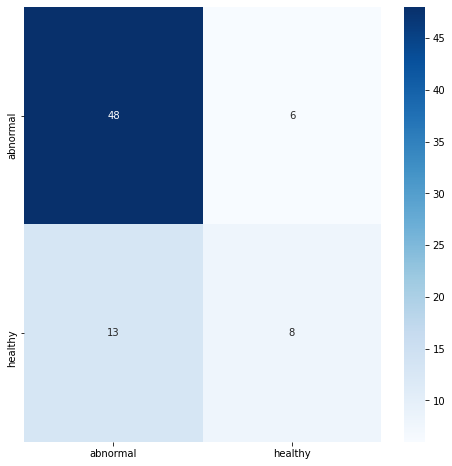

In [15]:
MobileNet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

MobileNet_model = model_training(MobileNet,'MobileNet.h5', 100)




-------------------- Model Initialized --------------------
Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 2.7101 - accuracy: 0.4012 - auc_6: 0.3924 - precision_6: 0.4012 - recall_6: 0.4012 - cohen_kappa: -0.9605 - f1_score: 0.3889

C:\Users\HSSL77\anaconda3\envs\tf_gpu_final\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
C:\Users\HSSL77\anaconda3\envs\tf_gpu_final\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_loss improved from inf to 2.92809, saving model to Vgg19.h5
21/21 [==============================] - 18s 647ms/step - loss: 2.7101 - accuracy: 0.4012 - auc_6: 0.3924 - precision_6: 0.4012 - recall_6: 0.4012 - cohen_kappa: -0.9605 - f1_score: 0.3889 - val_loss: 2.9281 - val_accuracy: 0.4400 - val_auc_6: 0.3961 - val_precision_6: 0.4400 - val_recall_6: 0.4400 - val_cohen_kappa: -0.9716 - val_f1_score: 0.4318 - lr: 1.0000e-05
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 2.5022 - accuracy: 0.5062 - auc_6: 0.5244 - precision_6: 0.5062 - recall_6: 0.5062 - cohen_kappa: -0.9973 - f1_score: 0.5055
Epoch 2: val_loss improved from 2.92809 to 2.61598, saving model to Vgg19.h5
21/21 [==============================] - 11s 522ms/step - loss: 2.5022 - accuracy: 0.5062 - auc_6: 0.5244 - precision_6: 0.5062 - recall_6: 0.5062 - cohen_kappa: -0.9973 - f1_score: 0.5055 - val_loss: 2.6160 - val_accuracy: 0.4800 - val_auc_6: 0.4886 - val_precision_6: 0.4800 - val_recal

21/21 [==============================] - ETA: 0s - loss: 1.8374 - accuracy: 0.9286 - auc_6: 0.9677 - precision_6: 0.9286 - recall_6: 0.9286 - cohen_kappa: -0.8491 - f1_score: 0.9222
Epoch 14: val_loss improved from 2.18592 to 2.18218, saving model to Vgg19.h5
21/21 [==============================] - 11s 511ms/step - loss: 1.8374 - accuracy: 0.9286 - auc_6: 0.9677 - precision_6: 0.9286 - recall_6: 0.9286 - cohen_kappa: -0.8491 - f1_score: 0.9222 - val_loss: 2.1822 - val_accuracy: 0.7200 - val_auc_6: 0.8198 - val_precision_6: 0.7200 - val_recall_6: 0.7200 - val_cohen_kappa: -0.5571 - val_f1_score: 0.6087 - lr: 1.0000e-05
Epoch 15/100
21/21 [==============================] - ETA: 0s - loss: 1.8078 - accuracy: 0.8750 - auc_6: 0.9694 - precision_6: 0.8750 - recall_6: 0.8750 - cohen_kappa: -0.8548 - f1_score: 0.8644
Epoch 15: val_loss improved from 2.18218 to 2.18217, saving model to Vgg19.h5
21/21 [==============================] - 11s 513ms/step - loss: 1.8078 - accuracy: 0.8750 - auc_6: 0

21/21 [==============================] - ETA: 0s - loss: 1.8618 - accuracy: 0.8929 - auc_6: 0.9551 - precision_6: 0.8929 - recall_6: 0.8929 - cohen_kappa: -0.7041 - f1_score: 0.8703
Epoch 27: val_loss improved from 2.15670 to 2.13879, saving model to Vgg19.h5
21/21 [==============================] - 11s 511ms/step - loss: 1.8618 - accuracy: 0.8929 - auc_6: 0.9551 - precision_6: 0.8929 - recall_6: 0.8929 - cohen_kappa: -0.7041 - f1_score: 0.8703 - val_loss: 2.1388 - val_accuracy: 0.7467 - val_auc_6: 0.8501 - val_precision_6: 0.7467 - val_recall_6: 0.7467 - val_cohen_kappa: -0.5571 - val_f1_score: 0.6460 - lr: 1.0000e-05
Epoch 28/100
21/21 [==============================] - ETA: 0s - loss: 1.7305 - accuracy: 0.9583 - auc_6: 0.9878 - precision_6: 0.9583 - recall_6: 0.9583 - cohen_kappa: -0.7256 - f1_score: 0.9505
Epoch 28: val_loss did not improve from 2.13879
21/21 [==============================] - 10s 490ms/step - loss: 1.7305 - accuracy: 0.9583 - auc_6: 0.9878 - precision_6: 0.9583 - 

21/21 [==============================] - 10s 491ms/step - loss: 1.6724 - accuracy: 0.9643 - auc_6: 0.9982 - precision_6: 0.9643 - recall_6: 0.9643 - cohen_kappa: -0.7185 - f1_score: 0.9573 - val_loss: 2.1789 - val_accuracy: 0.7600 - val_auc_6: 0.8580 - val_precision_6: 0.7600 - val_recall_6: 0.7600 - val_cohen_kappa: -0.4360 - val_f1_score: 0.6048 - lr: 1.0000e-05
Epoch 41/100
21/21 [==============================] - ETA: 0s - loss: 1.7348 - accuracy: 0.9691 - auc_6: 0.9953 - precision_6: 0.9691 - recall_6: 0.9691 - cohen_kappa: -0.7797 - f1_score: 0.9648
Epoch 41: val_loss did not improve from 2.13584
21/21 [==============================] - 10s 495ms/step - loss: 1.7348 - accuracy: 0.9691 - auc_6: 0.9953 - precision_6: 0.9691 - recall_6: 0.9691 - cohen_kappa: -0.7797 - f1_score: 0.9648 - val_loss: 2.2368 - val_accuracy: 0.7467 - val_auc_6: 0.8549 - val_precision_6: 0.7467 - val_recall_6: 0.7467 - val_cohen_kappa: -0.4188 - val_f1_score: 0.5709 - lr: 1.0000e-05
Epoch 42/100
21/21 [===

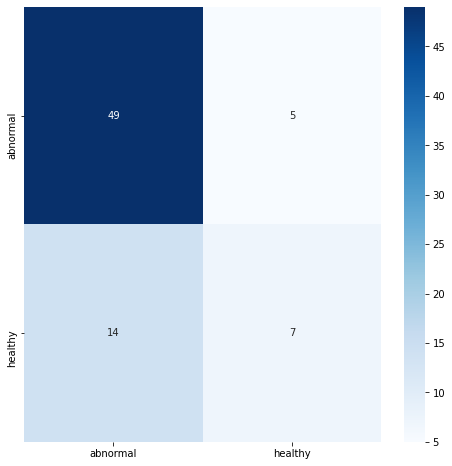

In [16]:
Vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

Vgg19 = model_training(MobileNet,'Vgg19.h5', 100)




-------------------- Model Initialized --------------------
Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 2.9621 - accuracy: 0.4226 - auc_7: 0.4112 - precision_7: 0.4226 - recall_7: 0.4226 - cohen_kappa: -0.9915 - f1_score: 0.4201

C:\Users\HSSL77\anaconda3\envs\tf_gpu_final\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
C:\Users\HSSL77\anaconda3\envs\tf_gpu_final\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_loss improved from inf to 2.90928, saving model to Xception.h5
21/21 [==============================] - 26s 707ms/step - loss: 2.9621 - accuracy: 0.4226 - auc_7: 0.4112 - precision_7: 0.4226 - recall_7: 0.4226 - cohen_kappa: -0.9915 - f1_score: 0.4201 - val_loss: 2.9093 - val_accuracy: 0.6800 - val_auc_7: 0.7708 - val_precision_7: 0.6800 - val_recall_7: 0.6800 - val_cohen_kappa: -0.7399 - val_f1_score: 0.6237 - lr: 1.0000e-05
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 2.8433 - accuracy: 0.6420 - auc_7: 0.6676 - precision_7: 0.6420 - recall_7: 0.6420 - cohen_kappa: -0.9570 - f1_score: 0.6339
Epoch 2: val_loss did not improve from 2.90928
21/21 [==============================] - 14s 646ms/step - loss: 2.8433 - accuracy: 0.6420 - auc_7: 0.6676 - precision_7: 0.6420 - recall_7: 0.6420 - cohen_kappa: -0.9570 - f1_score: 0.6339 - val_loss: 2.9094 - val_accuracy: 0.6933 - val_auc_7: 0.7288 - val_precision_7: 0.6933 - val_recall_7: 0.6933 - val_cohen_kap

21/21 [==============================] - 17s 808ms/step - loss: 2.3904 - accuracy: 0.9012 - auc_7: 0.9656 - precision_7: 0.9012 - recall_7: 0.9012 - cohen_kappa: -0.7728 - f1_score: 0.8867 - val_loss: 2.7207 - val_accuracy: 0.7200 - val_auc_7: 0.8318 - val_precision_7: 0.7200 - val_recall_7: 0.7200 - val_cohen_kappa: -0.3846 - val_f1_score: 0.4960 - lr: 1.0000e-05
Epoch 15/100
21/21 [==============================] - ETA: 0s - loss: 2.3410 - accuracy: 0.9383 - auc_7: 0.9851 - precision_7: 0.9383 - recall_7: 0.9383 - cohen_kappa: -0.7728 - f1_score: 0.9292
Epoch 15: val_loss did not improve from 2.72073
21/21 [==============================] - 14s 681ms/step - loss: 2.3410 - accuracy: 0.9383 - auc_7: 0.9851 - precision_7: 0.9383 - recall_7: 0.9383 - cohen_kappa: -0.7728 - f1_score: 0.9292 - val_loss: 2.7222 - val_accuracy: 0.7333 - val_auc_7: 0.8340 - val_precision_7: 0.7333 - val_recall_7: 0.7333 - val_cohen_kappa: -0.3676 - val_f1_score: 0.5040 - lr: 1.0000e-05
Epoch 16/100
21/21 [===

Epoch 28/100
21/21 [==============================] - ETA: 0s - loss: 2.1151 - accuracy: 0.9881 - auc_7: 0.9994 - precision_7: 0.9881 - recall_7: 0.9881 - cohen_kappa: -0.7870 - f1_score: 0.9865
Epoch 28: val_loss did not improve from 2.62243
21/21 [==============================] - 15s 715ms/step - loss: 2.1151 - accuracy: 0.9881 - auc_7: 0.9994 - precision_7: 0.9881 - recall_7: 0.9881 - cohen_kappa: -0.7870 - f1_score: 0.9865 - val_loss: 2.6278 - val_accuracy: 0.7200 - val_auc_7: 0.8368 - val_precision_7: 0.7200 - val_recall_7: 0.7200 - val_cohen_kappa: -0.3507 - val_f1_score: 0.4608 - lr: 1.0000e-05
Epoch 29/100
21/21 [==============================] - ETA: 0s - loss: 2.1067 - accuracy: 0.9762 - auc_7: 0.9994 - precision_7: 0.9762 - recall_7: 0.9762 - cohen_kappa: -0.7185 - f1_score: 0.9715
Epoch 29: val_loss improved from 2.62243 to 2.61633, saving model to Xception.h5
21/21 [==============================] - 17s 790ms/step - loss: 2.1067 - accuracy: 0.9762 - auc_7: 0.9994 - precis

21/21 [==============================] - ETA: 0s - loss: 1.9540 - accuracy: 1.0000 - auc_7: 1.0000 - precision_7: 1.0000 - recall_7: 1.0000 - cohen_kappa: -0.7300 - f1_score: 1.0000
Epoch 41: val_loss did not improve from 2.55174
21/21 [==============================] - 14s 690ms/step - loss: 1.9540 - accuracy: 1.0000 - auc_7: 1.0000 - precision_7: 1.0000 - recall_7: 1.0000 - cohen_kappa: -0.7300 - f1_score: 1.0000 - val_loss: 2.5531 - val_accuracy: 0.7467 - val_auc_7: 0.8222 - val_precision_7: 0.7467 - val_recall_7: 0.7467 - val_cohen_kappa: -0.3846 - val_f1_score: 0.5440 - lr: 1.0000e-05
Epoch 42/100
21/21 [==============================] - ETA: 0s - loss: 1.9305 - accuracy: 1.0000 - auc_7: 1.0000 - precision_7: 1.0000 - recall_7: 1.0000 - cohen_kappa: -0.7004 - f1_score: 1.0000
Epoch 42: val_loss did not improve from 2.55174
21/21 [==============================] - 14s 665ms/step - loss: 1.9305 - accuracy: 1.0000 - auc_7: 1.0000 - precision_7: 1.0000 - recall_7: 1.0000 - cohen_kappa

21/21 [==============================] - ETA: 0s - loss: 1.7879 - accuracy: 0.9940 - auc_7: 1.0000 - precision_7: 0.9940 - recall_7: 0.9940 - cohen_kappa: -0.7256 - f1_score: 0.9929
Epoch 54: val_loss did not improve from 2.43865
21/21 [==============================] - 12s 580ms/step - loss: 1.7879 - accuracy: 0.9940 - auc_7: 1.0000 - precision_7: 0.9940 - recall_7: 0.9940 - cohen_kappa: -0.7256 - f1_score: 0.9929 - val_loss: 2.4560 - val_accuracy: 0.7467 - val_auc_7: 0.8238 - val_precision_7: 0.7467 - val_recall_7: 0.7467 - val_cohen_kappa: -0.3846 - val_f1_score: 0.5440 - lr: 1.0000e-05
Epoch 55/100
21/21 [==============================] - ETA: 0s - loss: 1.7863 - accuracy: 0.9940 - auc_7: 0.9997 - precision_7: 0.9940 - recall_7: 0.9940 - cohen_kappa: -0.7113 - f1_score: 0.9928
Epoch 55: val_loss improved from 2.43865 to 2.43052, saving model to Xception.h5
21/21 [==============================] - 13s 595ms/step - loss: 1.7863 - accuracy: 0.9940 - auc_7: 0.9997 - precision_7: 0.9940

21/21 [==============================] - ETA: 0s - loss: 1.6579 - accuracy: 0.9938 - auc_7: 0.9999 - precision_7: 0.9938 - recall_7: 0.9938 - cohen_kappa: -0.5842 - f1_score: 0.9916
Epoch 67: val_loss improved from 2.29208 to 2.21692, saving model to Xception.h5
21/21 [==============================] - 16s 808ms/step - loss: 1.6579 - accuracy: 0.9938 - auc_7: 0.9999 - precision_7: 0.9938 - recall_7: 0.9938 - cohen_kappa: -0.5842 - f1_score: 0.9916 - val_loss: 2.2169 - val_accuracy: 0.7467 - val_auc_7: 0.8503 - val_precision_7: 0.7467 - val_recall_7: 0.7467 - val_cohen_kappa: -0.3846 - val_f1_score: 0.5440 - lr: 1.0000e-05
Epoch 68/100
21/21 [==============================] - ETA: 0s - loss: 1.6312 - accuracy: 1.0000 - auc_7: 1.0000 - precision_7: 1.0000 - recall_7: 1.0000 - cohen_kappa: -0.7728 - f1_score: 1.0000
Epoch 68: val_loss did not improve from 2.21692
21/21 [==============================] - 15s 727ms/step - loss: 1.6312 - accuracy: 1.0000 - auc_7: 1.0000 - precision_7: 1.0000

21/21 [==============================] - ETA: 0s - loss: 1.4994 - accuracy: 1.0000 - auc_7: 1.0000 - precision_7: 1.0000 - recall_7: 1.0000 - cohen_kappa: -0.7465 - f1_score: 1.0000
Epoch 80: val_loss did not improve from 2.13009
21/21 [==============================] - 16s 761ms/step - loss: 1.4994 - accuracy: 1.0000 - auc_7: 1.0000 - precision_7: 1.0000 - recall_7: 1.0000 - cohen_kappa: -0.7465 - f1_score: 1.0000 - val_loss: 2.1468 - val_accuracy: 0.7467 - val_auc_7: 0.8405 - val_precision_7: 0.7467 - val_recall_7: 0.7467 - val_cohen_kappa: -0.3846 - val_f1_score: 0.5440 - lr: 1.0000e-05
Epoch 81/100
21/21 [==============================] - ETA: 0s - loss: 1.4687 - accuracy: 1.0000 - auc_7: 1.0000 - precision_7: 1.0000 - recall_7: 1.0000 - cohen_kappa: -0.6303 - f1_score: 1.0000
Epoch 81: val_loss did not improve from 2.13009
21/21 [==============================] - 15s 723ms/step - loss: 1.4687 - accuracy: 1.0000 - auc_7: 1.0000 - precision_7: 1.0000 - recall_7: 1.0000 - cohen_kappa

21/21 [==============================] - ETA: 0s - loss: 1.3230 - accuracy: 1.0000 - auc_7: 1.0000 - precision_7: 1.0000 - recall_7: 1.0000 - cohen_kappa: -0.6897 - f1_score: 1.0000
Epoch 93: val_loss improved from 2.03236 to 2.01373, saving model to Xception.h5
21/21 [==============================] - 18s 845ms/step - loss: 1.3230 - accuracy: 1.0000 - auc_7: 1.0000 - precision_7: 1.0000 - recall_7: 1.0000 - cohen_kappa: -0.6897 - f1_score: 1.0000 - val_loss: 2.0137 - val_accuracy: 0.7333 - val_auc_7: 0.8398 - val_precision_7: 0.7333 - val_recall_7: 0.7333 - val_cohen_kappa: -0.3676 - val_f1_score: 0.5040 - lr: 1.0000e-05
Epoch 94/100
21/21 [==============================] - ETA: 0s - loss: 1.3201 - accuracy: 1.0000 - auc_7: 1.0000 - precision_7: 1.0000 - recall_7: 1.0000 - cohen_kappa: -0.6701 - f1_score: 1.0000
Epoch 94: val_loss improved from 2.01373 to 1.97957, saving model to Xception.h5
21/21 [==============================] - 18s 835ms/step - loss: 1.3201 - accuracy: 1.0000 - au

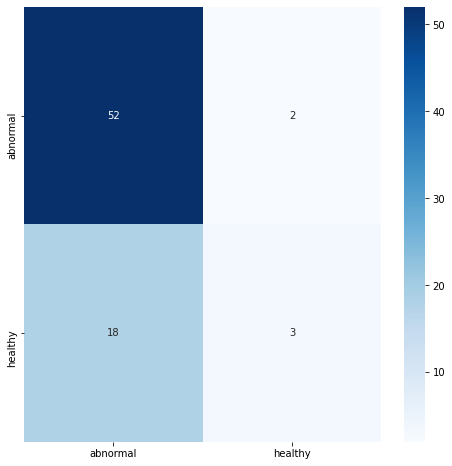

In [17]:
Xception = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

Xception = model_training(Xception,'Xception.h5', 100)




-------------------- Model Initialized --------------------
Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 3.0863 - accuracy: 0.5802 - auc_8: 0.6269 - precision_8: 0.5802 - recall_8: 0.5802 - cohen_kappa: -0.7865 - f1_score: 0.5233

C:\Users\HSSL77\anaconda3\envs\tf_gpu_final\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
C:\Users\HSSL77\anaconda3\envs\tf_gpu_final\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_loss improved from inf to 3.12068, saving model to InceptionV3.h5
21/21 [==============================] - 41s 1s/step - loss: 3.0863 - accuracy: 0.5802 - auc_8: 0.6269 - precision_8: 0.5802 - recall_8: 0.5802 - cohen_kappa: -0.7865 - f1_score: 0.5233 - val_loss: 3.1207 - val_accuracy: 0.4000 - val_auc_8: 0.3599 - val_precision_8: 0.4000 - val_recall_8: 0.4000 - val_cohen_kappa: -0.9943 - val_f1_score: 0.3983 - lr: 1.0000e-05
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 2.7807 - accuracy: 0.7560 - auc_8: 0.8640 - precision_8: 0.7560 - recall_8: 0.7560 - cohen_kappa: -0.8190 - f1_score: 0.7290
Epoch 2: val_loss improved from 3.12068 to 2.95281, saving model to InceptionV3.h5
21/21 [==============================] - 17s 823ms/step - loss: 2.7807 - accuracy: 0.7560 - auc_8: 0.8640 - precision_8: 0.7560 - recall_8: 0.7560 - cohen_kappa: -0.8190 - f1_score: 0.7290 - val_loss: 2.9528 - val_accuracy: 0.5067 - val_auc_8: 0.6002 - val_precision_8: 0.5067 - 

21/21 [==============================] - ETA: 0s - loss: 2.3666 - accuracy: 0.9444 - auc_8: 0.9857 - precision_8: 0.9444 - recall_8: 0.9444 - cohen_kappa: -0.6624 - f1_score: 0.9303
Epoch 14: val_loss did not improve from 2.73181
21/21 [==============================] - 11s 529ms/step - loss: 2.3666 - accuracy: 0.9444 - auc_8: 0.9857 - precision_8: 0.9444 - recall_8: 0.9444 - cohen_kappa: -0.6624 - f1_score: 0.9303 - val_loss: 2.8082 - val_accuracy: 0.7067 - val_auc_8: 0.8103 - val_precision_8: 0.7067 - val_recall_8: 0.7067 - val_cohen_kappa: -0.4706 - val_f1_score: 0.5417 - lr: 1.0000e-05
Epoch 15/100
21/21 [==============================] - ETA: 0s - loss: 2.4022 - accuracy: 0.9259 - auc_8: 0.9833 - precision_8: 0.9259 - recall_8: 0.9259 - cohen_kappa: -0.7587 - f1_score: 0.9141
Epoch 15: val_loss did not improve from 2.73181
21/21 [==============================] - 12s 560ms/step - loss: 2.4022 - accuracy: 0.9259 - auc_8: 0.9833 - precision_8: 0.9259 - recall_8: 0.9259 - cohen_kappa

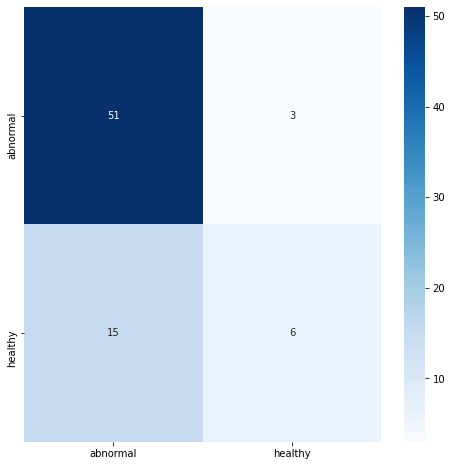

In [18]:
InceptionV3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

InceptionV3 = model_training(InceptionV3,'InceptionV3.h5', 100)




-------------------- Model Initialized --------------------
Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 2.5552 - accuracy: 0.7500 - auc_9: 0.7982 - precision_9: 0.7500 - recall_9: 0.7500 - cohen_kappa: -0.4305 - f1_score: 0.5846

C:\Users\HSSL77\anaconda3\envs\tf_gpu_final\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
C:\Users\HSSL77\anaconda3\envs\tf_gpu_final\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_loss improved from inf to 2.14713, saving model to DenseNet121.h5
21/21 [==============================] - 33s 767ms/step - loss: 2.5552 - accuracy: 0.7500 - auc_9: 0.7982 - precision_9: 0.7500 - recall_9: 0.7500 - cohen_kappa: -0.4305 - f1_score: 0.5846 - val_loss: 2.1471 - val_accuracy: 0.7867 - val_auc_9: 0.8361 - val_precision_9: 0.7867 - val_recall_9: 0.7867 - val_cohen_kappa: -0.5052 - val_f1_score: 0.6822 - lr: 1.0000e-05
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 2.2626 - accuracy: 0.8333 - auc_9: 0.8860 - precision_9: 0.8333 - recall_9: 0.8333 - cohen_kappa: -0.5386 - f1_score: 0.7619
Epoch 2: val_loss improved from 2.14713 to 2.12212, saving model to DenseNet121.h5
21/21 [==============================] - 15s 702ms/step - loss: 2.2626 - accuracy: 0.8333 - auc_9: 0.8860 - precision_9: 0.8333 - recall_9: 0.8333 - cohen_kappa: -0.5386 - f1_score: 0.7619 - val_loss: 2.1221 - val_accuracy: 0.8000 - val_auc_9: 0.8484 - val_precision_9: 0.8000

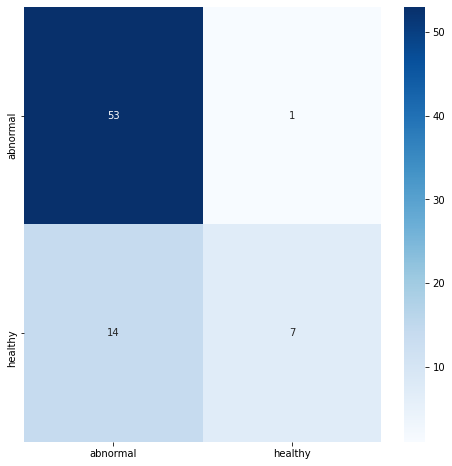

In [19]:
DenseNet121 = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

DenseNet121 = model_training(DenseNet121,'DenseNet121.h5', 100)




-------------------- Model Initialized --------------------
Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 2.3289 - accuracy: 0.6481 - auc_10: 0.6821 - precision_10: 0.6481 - recall_10: 0.6481 - cohen_kappa: -0.8447 - f1_score: 0.6158

C:\Users\HSSL77\anaconda3\envs\tf_gpu_final\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
C:\Users\HSSL77\anaconda3\envs\tf_gpu_final\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_loss improved from inf to 1.79396, saving model to Vgg16.h5
21/21 [==============================] - 24s 841ms/step - loss: 2.3289 - accuracy: 0.6481 - auc_10: 0.6821 - precision_10: 0.6481 - recall_10: 0.6481 - cohen_kappa: -0.8447 - f1_score: 0.6158 - val_loss: 1.7940 - val_accuracy: 0.6933 - val_auc_10: 0.7893 - val_precision_10: 0.6933 - val_recall_10: 0.6933 - val_cohen_kappa: -0.7854 - val_f1_score: 0.6514 - lr: 1.0000e-05
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 1.5495 - accuracy: 0.8393 - auc_10: 0.9105 - precision_10: 0.8393 - recall_10: 0.8393 - cohen_kappa: -0.7670 - f1_score: 0.8149
Epoch 2: val_loss improved from 1.79396 to 1.77667, saving model to Vgg16.h5
21/21 [==============================] - 14s 683ms/step - loss: 1.5495 - accuracy: 0.8393 - auc_10: 0.9105 - precision_10: 0.8393 - recall_10: 0.8393 - cohen_kappa: -0.7670 - f1_score: 0.8149 - val_loss: 1.7767 - val_accuracy: 0.7733 - val_auc_10: 0.8437 - val_precision_10: 0.77

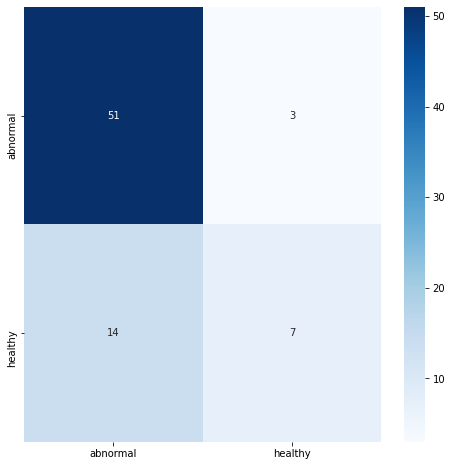

In [20]:
Vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

Vgg16 = model_training(Vgg16,'Vgg16.h5', 100)

In [22]:
df = pd.DataFrame(l)
df

,Model,loss,accuracy,auc,precision,recall,f1_score,cohen_kappa,cm,cr
0,MobileNet.h5,2.196022,0.746667,0.819378,0.746667,0.746667,-0.557093,"[0.83478266, 0.45714286]","[[48, 6], [13, 8]]",precision recall f1-score ...
1,Vgg19.h5,2.135838,0.746667,0.852622,0.746667,0.746667,-0.522534,"[0.83760685, 0.42424244]","[[49, 5], [14, 7]]",precision recall f1-score ...
2,Xception.h5,1.826214,0.733333,0.853689,0.733333,0.733333,-0.401694,"[0.8387097, 0.23076925]","[[52, 2], [18, 3]]",precision recall f1-score ...
3,InceptionV3.h5,2.731813,0.760000,0.850756,0.760000,0.760000,-0.470588,"[0.85, 0.4]","[[51, 3], [15, 6]]",precision recall f1-score ...
4,DenseNet121.h5,2.122121,0.800000,0.848356,0.800000,0.800000,-0.453301,"[0.87603307, 0.48275864]","[[53, 1], [14, 7]]",precision recall f1-score ...
5,Vgg16.h5,1.776670,0.773333,0.843733,0.773333,0.773333,-0.487898,"[0.85714287, 0.45161292]","[[51, 3], [14, 7]]",precision recall f1-score ...
